In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from decimal import Decimal
import random
import albumentations as A

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!pwd

Mounted at /content/gdrive
/content


## RandomSizedBBoxSafeCrop

In [ ]:
def yolo_transform_crop(img, yolo_coords):
  image_height, image_width = img.shape[:2]
  yolo_box = []
  class_labels =[]
  for a in yolo_coords:
    class_id, xmin, xmax, ymin, ymax = a
    b = [xmin, xmax, ymin, ymax]
    yolo_box.append(b)
    label = int(class_id)
    class_labels.append(label)
  
  transform = A.Compose([A.RandomSizedBBoxSafeCrop(width=image_width, height=image_height, erosion_rate=0.5)
  ], bbox_params=A.BboxParams(format='yolo', label_fields=['category_ids']))
  transformed = transform(image=img, bboxes=yolo_box, category_ids=class_labels)
  
  return transformed

##Plotting the image and box

In [ ]:
# Convert box coordinate from yolo to cv
def yoloFormattocv(x1, y1, x2, y2, H, W):
    bbox_width = x2 * W
    bbox_height = y2 * H
    center_x = x1 * W
    center_y = y1 * H
    cv = []
    cv.append(center_x - (bbox_width / 2))
    cv.append(center_y - (bbox_height / 2))
    cv.append(center_x + (bbox_width / 2))
    cv.append(center_y + (bbox_height / 2))
    return [int(v) for v in cv]

In [ ]:
# defining box name and color
box_color = {0:'blue',1:'orange',2:'green',3:'purple',4:'brown',5:'pink',
             6:'gray',7:'olive',8:'cyan',9:'gold',10:'turquoise',11:'navy',12:'yellow',13:'red'}
box_name = {0:'RazorBlade',1:'SafetyPin',2:'PaperClip',3:'Pen',4:'ThinNail',5:'Screw',
            6:'HandGun',7:'VgaConnector',8:'Knife',9:'MultiPurposeKnife',10:'Key',11:'Plier',12:'Shuriken',13:'Scissor'}

In [ ]:
#plotting the image with the box
def plot_img_box_orginial(img, yolo_coords):
  image_height, image_width = img.shape[:2]
  plt.imshow(img)
  for row in yolo_coords:
    [x1,y1,x2,y2] = yoloFormattocv(float(row[1]),float(row[2]),float(row[3]),float(row[4]),image_height, image_width)
    plt.gca().add_patch(Rectangle((x1,y1),x2-x1,y2-y1, edgecolor=box_color[int(row[0])], facecolor='none', lw=1))
    plt.annotate(box_name[int(row[0])], ((x2+x1)/2, (y2+y1)/2), 
                 color=box_color[int(row[0])], weight='bold', fontsize=10, ha='center', va='center') # label at the center of the box

In [ ]:
#plotting the image with the box

def plot_img_box_transformed(img, box, label):
  image_height, image_width = img.shape[:2]
  plt.imshow(img)
  combined=box
  for i in range(len(label)):
    combined[i] = (label[i],)+ box[i]
  
  for row in combined:
    [x1,y1,x2,y2] = yoloFormattocv(float(row[1]),float(row[2]),float(row[3]),float(row[4]),image_height, image_width)
    plt.gca().add_patch(Rectangle((x1,y1),x2-x1,y2-y1, edgecolor=box_color[row[0]], facecolor='none', lw=1))
    plt.annotate(box_name[row[0]], ((x2+x1)/2, (y2+y1)/2), 
                 color=box_color[row[0]], weight='bold', fontsize=10, ha='center', va='center') # label at the center of the box

##Test 1

In [ ]:
# example usage
txt_file_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/labels/B0002_0001.txt"
img_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/images/B0002_0001.png"

In [ ]:
# read YOLO format bbox coordinates from text file
with open(txt_file_path, "r") as f:
    yolo_coords = [list(map(float, line.strip().split())) for line in f.readlines()]

In [ ]:
# read image to get its dimensions
img = cv2.imread(img_path)

In [ ]:
a = yolo_transform_crop(img, yolo_coords)

In [ ]:
image= a['image']
box = a['bboxes']
label = a['category_ids']

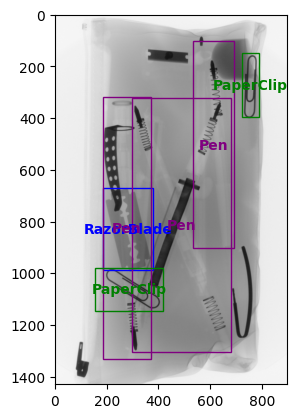

In [ ]:
plot_img_box_orginial(img, yolo_coords)

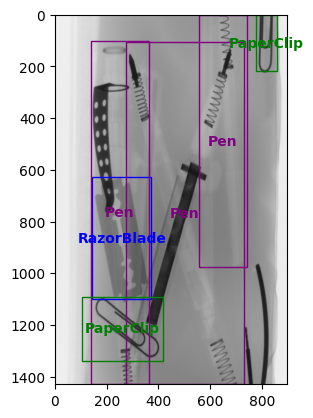

In [ ]:
plot_img_box_transformed(image, box, label)

## Test 2

In [ ]:
# example usage
txt_file_path2 = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/labels/B0015_0004.txt"
img_path2 = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/images/B0015_0004.png"

In [ ]:
# read YOLO format bbox coordinates from text file
with open(txt_file_path2, "r") as f:
    yolo_coords2 = [list(map(float, line.strip().split())) for line in f.readlines()]

In [ ]:
# read image to get its dimensions
img2 = cv2.imread(img_path2)

In [ ]:
a2 = yolo_transform_crop(img2, yolo_coords2)

In [ ]:
image2= a2['image']
box2 = a2['bboxes']
label2 = a2['category_ids']

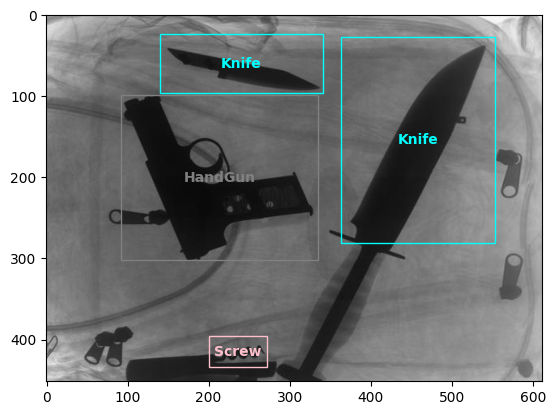

In [ ]:
plot_img_box_orginial(img2, yolo_coords2)

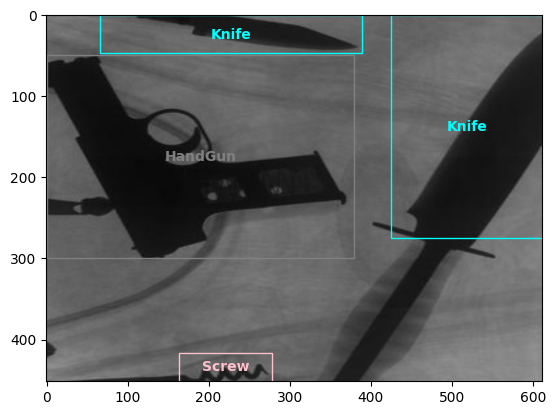

In [ ]:
plot_img_box_transformed(image2, box2, label2)

## Transforming images from folder path

In [66]:
def generate_cropped_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path):
  
  # Extract image & annotation name
  image_list = [i for i in listdir(image_folder_path) if isfile(join(image_folder_path, i))]
  annotation_list = [i for i in listdir(annotation_folder_path) if isfile(join(annotation_folder_path, i))]

  # Loop through each image
  count = 0
  for img_name, annotation_name in zip(image_list, annotation_list):
    count = count + 1
    full_path_img = image_folder_path + "/" + img_name
    full_path_coords = annotation_folder_path + "/" + annotation_name

    #opening image and txt file
    img = cv2.imread(full_path_img)
    with open(full_path_coords, "r") as f:
      yolo_coords = [list(map(float, line.strip().split())) for line in f.readlines()]
  
    #applying the transformation
    cropped = yolo_transform_crop(img, yolo_coords)
    images = cropped['image']

    #saving the image
    cv2.imwrite(save_img_pth + "/" + 'cropped_' + img_name, images)

    #creating combined coordinates with labels
    box = cropped['bboxes']
    label = cropped['category_ids']
    combined=box
    for i in range(len(label)):
      combined[i] = str((label[i],)+ box[i])
      combined[i] = combined[i].replace(",", "")
      combined[i] = combined[i].replace("(", "")
      combined[i] = combined[i].replace(")", "")

    file_name = save_annotation_path + "/" +'cropped_'+ annotation_name
    with open(file_name, 'w') as fp:
      for i in range(len(combined)):
        if i < (len(combined)-1):
          fp.write(combined[i]+"\n") # add break line for items not the last one
        else:
          fp.write(combined[i]) # no break line for last item (avoid empty row)

## Saving Images

In [69]:
#get images
image_folder_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/images"
annotation_folder_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train/labels"

#save images
save_img_pth = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train_cropped/images"
save_annotation_path = "/content/gdrive/MyDrive/M2/CRP/CRP - Shared Folder/CRP__Dataset_Repartition/train_cropped/labels"

In [70]:
generate_cropped_image(image_folder_path, annotation_folder_path, save_img_pth, save_annotation_path)